## 1. Maryland crime data
<p>Crime rates vary across space and time. The reasons crimes are committed in some places but not others can be difficult to detect because of complex socio-economic factors, but policymakers still need to understand how crime rates are changing from place to place and from time to time to inform their policies.   </p>
<p>Many government statistics, such as crime rates, come from nested datasets. Most US States are divided into counties (Alaska has “burrows,” and  Louisiana has “parishes”), and counties and county-level governments can vary within the same state. For example, one county might have a high population density and be urban, whereas a second county might have a low population density and be rural. </p>
<p>In this project we will use a form of regression called hierarchical modeling to capture and explore <a href="http://goccp.maryland.gov/crime-statistics/">crime statistics</a> collected by the State of Maryland to see if there is a linear trend in violent crime across the state between 1975 and 2016. These data come from the <a href="https://ccjs.umd.edu/research/maryland-data-analysis-center">Maryland Statistical Analysis Center</a>. </p>
<p>This figure shows population per county across the state of Maryland in 2016. By the end of the project, we will create a similar figure for each county's crime rate.</p>
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" alt="Map of Maryland counties and population"></p>
<p>Before running a regression analysis, we often need to tidy data. Everyday tidying tasks include renaming and reformatting columns. Luckily, the <a href="https://www.tidyverse.org/">Tidyverse</a> exists!</p>

In [22]:
# Load the packages
library(tidyverse)
library(lubridate)

# Read in the crime data
crime_raw <- read_csv("datasets/Violent_Crime_by_County_1975_to_2016.csv")

# Select and mutate columns the needed columns
crime_use <- crime_raw %>% 
    select(JURISDICTION, YEAR, POPULATION, crime_rate = `VIOLENT CRIME RATE PER 100,000 PEOPLE`) %>%
    mutate(YEAR_2 = year(mdy_hms(YEAR)))

# Peek at the data
head(crime_use)

Parsed with column specification:
cols(
  .default = col_double(),
  JURISDICTION = col_character(),
  YEAR = col_character(),
  POPULATION = col_integer(),
  MURDER = col_integer(),
  RAPE = col_integer(),
  ROBBERY = col_integer(),
  `AGG. ASSAULT` = col_integer(),
  `B & E` = col_integer(),
  `LARCENY THEFT` = col_integer(),
  `M/V THEFT` = col_integer(),
  `GRAND TOTAL` = col_integer(),
  `VIOLENT CRIME TOTAL` = col_integer(),
  `PROPERTY CRIME TOTALS` = col_integer()
)
See spec(...) for full column specifications.


JURISDICTION,YEAR,POPULATION,crime_rate,YEAR_2
Allegany County,01/01/1975 12:00:00 AM,79655,178.3,1975
Allegany County,01/01/1976 12:00:00 AM,83923,103.7,1976
Allegany County,01/01/1977 12:00:00 AM,82102,154.7,1977
Allegany County,01/01/1978 12:00:00 AM,79966,127.6,1978
Allegany County,01/01/1979 12:00:00 AM,79721,138.0,1979
Allegany County,01/01/1980 12:00:00 AM,80461,147.9,1980


## 2. Raw data and trend lines
<p>Before running a regression or building a model, it's a good idea to explore the data. Exploratory data analysis (EDA) will help us see outliers, possible data errors, or trends. There is no single coding technique for EDA, but plotting the data is a great first step. A picture (or well-designed figure) can be worth a thousand summary statistics!</p>
<p>Let's plot the crime rate over time for each county and add a linear trend line.</p>

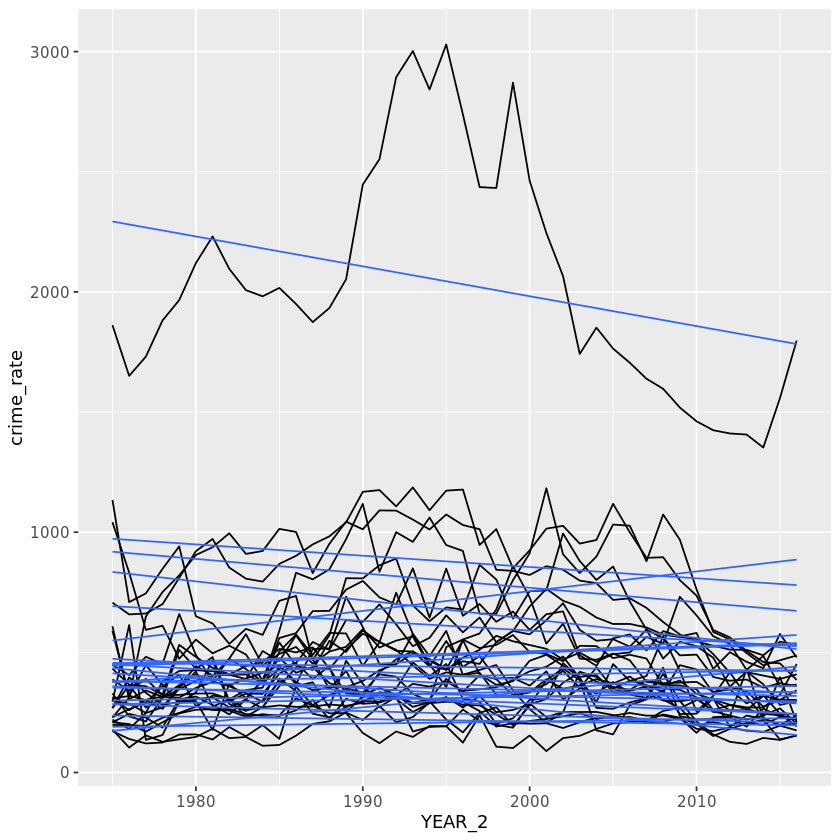

In [24]:
# Plot the data as lines and linear trend lines
ggplot(crime_use, aes(x = YEAR_2, y = crime_rate, group = JURISDICTION)) + 
    geom_line() + 
    geom_smooth(method = "lm", se = FALSE, size = 0.5)

## 3. Re-scale the data
<p>Prior to building a linear mixed-effects regression model, we need to re-scale the <code>YEAR_2</code> variable. In the raw data, <code>YEAR_2</code> starts at 1976, but regression models work best when the intercept is near zero. If we try to use <code>YEAR_2</code> without re-scaling it, the model will fail to converge. </p>
<p>We'll create a new variable, <code>YEAR_3</code> that starts at zero instead of 1976.</p>

In [26]:
# Mutate data to create another year column, YEAR_3
crime_use <- crime_use %>%
                mutate(YEAR_3 = YEAR_2 - min(YEAR_2))
head(crime_use)

JURISDICTION,YEAR,POPULATION,crime_rate,YEAR_2,YEAR_3
Allegany County,01/01/1975 12:00:00 AM,79655,178.3,1975,0
Allegany County,01/01/1976 12:00:00 AM,83923,103.7,1976,1
Allegany County,01/01/1977 12:00:00 AM,82102,154.7,1977,2
Allegany County,01/01/1978 12:00:00 AM,79966,127.6,1978,3
Allegany County,01/01/1979 12:00:00 AM,79721,138.0,1979,4
Allegany County,01/01/1980 12:00:00 AM,80461,147.9,1980,5


## 4. Build a LMER
<p>Now we can build a hierarchical model, also known as a linear mixed-effects regression model, using <code>lmer()</code>. <code>lmer()</code> uses syntax similar to <code>lm()</code>, but it requires a random-effect argument. For example, <code>y</code> predicted by fixed-effect slope, <code>x</code> , and random-effect intercept, <code>group</code> , would be <code>y ~ x + (1|group)</code>. <code>x</code> can also be included as a random-effect slope: <code>y ~ x + (x|group)</code>. <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed Effect Models</a> covers these models in greater detail.</p>
<p>We are going to see if a linear trend through time can predict violent crime rates. We will estimate the crime trend for the entire state (a fixed-effect slope) and trends for each county (random-effect slopes). By treating each county as a random-effect, we assume the trend for each county comes from a state-wide distribution. </p>
<p>We'll use the <code>lmerTest</code> package because it adds <em>p</em>-values for fixed-effect coefficients to <code>lmer()</code> models, something the <code>lme4</code> package does not include for <a href="http://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#why-doesnt-lme4-display-denominator-degrees-of-freedomp-values-what-other-options-do-i-have">reasons listed on the project's FAQ page</a>. </p>

In [28]:
# load the lmerTest package
library(lmerTest)

# Build a lmer and save it as lmer_crime
lmer_crime <- lmer(crime_rate ~ YEAR_3 + (YEAR_3|JURISDICTION), crime_use)

# Print the model output
lmer_crime

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: crime_rate ~ YEAR_3 + (YEAR_3 | JURISDICTION)
   Data: crime_use
REML criterion at convergence: 13144.44
Random effects:
 Groups       Name        Std.Dev. Corr 
 JURISDICTION (Intercept) 427.846       
              YEAR_3        4.235  -0.69
 Residual                 152.125       
Number of obs: 1008, groups:  JURISDICTION, 24
Fixed Effects:
(Intercept)       YEAR_3  
    529.031       -1.425  

## 5. Model outputs
<p>Let's examine the model's output. <code>lmer()</code> outputs are similar to <code>lm()</code> outputs, but <code>lmer()</code> outputs include extra information about both fixed- and random-effects. The <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed-effects Models course</a> provides more information on <code>lmer()</code> summary outputs. </p>
<p>The fixed-effect trend for <code>YEAR_3</code> is not significantly different from zero, but what do the estimates look like for different counties?  We can access the regression coefficients using <code>fixef()</code> and <code>ranef()</code>.</p>

In [30]:
# Examine the model outputs using summary
summary(lmer_crime)

# This is for readability 
noquote("**** Fixed-effects ****")

# Use fixef() to view fixed-effects
fixef(lmer_crime)

# This is for readability 
noquote("**** Random-effects ****")

# Use ranef() to view random-effects
ranef(lmer_crime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: crime_rate ~ YEAR_3 + (YEAR_3 | JURISDICTION)
   Data: crime_use

REML criterion at convergence: 13144.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4466 -0.4675 -0.0546  0.4328  6.5169 

Random effects:
 Groups       Name        Variance  Std.Dev. Corr 
 JURISDICTION (Intercept) 183052.41 427.846       
              YEAR_3          17.93   4.235  -0.69
 Residual                  23141.94 152.125       
Number of obs: 1008, groups:  JURISDICTION, 24

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept) 529.0308    87.8397  23.0001   6.023 3.84e-06 ***
YEAR_3       -1.4246     0.9506  23.0000  -1.499    0.148    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
       (Intr)
YEAR_3 -0.660

[1] **** Fixed-effects ****

(Intercept)      YEAR_3 
 529.030782   -1.424551

[1] **** Random-effects ****

$JURISDICTION
                       (Intercept)       YEAR_3
Allegany County         -324.40279   6.38773189
Anne Arundel County     -125.56798   4.81452725
Baltimore City          1751.63637 -10.69297722
Baltimore County         376.31193  -3.94824284
Calvert County          -132.90675  -1.82528994
Caroline County         -143.09958   2.15638117
Carroll County          -297.05247   0.75044023
Cecil County             -68.66563   2.77901515
Charles County           -60.79521   2.70968862
Dorchester County        154.05777  -2.19190576
Frederick County         -67.79590  -1.42734755
Garrett County          -335.53249   2.19623911
Harford County          -179.92000   0.25555894
Howard County           -123.98283  -3.82367106
Kent County             -220.62748   2.49301918
Montgomery County       -253.86110   0.03512392
Prince George's County   437.96789  -3.06292844
Queen Anne's County     -181.20167  -0.78720553
Somerset County          -71.53295   0.55554707
St. Mary's County       -1

## 6. Format model coefficients
<p>We estimated the crime rate for the entire state as a fixed-effect - this is the average crime rate across all of Maryland. We also estimated the crime rate for each county as a random-effect. To get the specific random-effect slope estimated for each county, we need to calucalate the difference between the county crime rate and the state average crime rate. For example, Allegany County had a slope estimate of 6.4 and Maryland had a slope estimate of -1.4. Adding these together, we get an estimated slope of 5.0 \(6.4 + -1.4 = 5.0\) for Allegany County. </p>
<p>We can use R to calculate the slope estimate for each county by extracting the fixed-effect estimate and adding it to the random-effect estimates. </p>

In [32]:
# Add the fixed-effect to the random-effect and save as county_slopes
county_slopes <- fixef(lmer_crime)["YEAR_3"] + ranef(lmer_crime)$JURISDICTION["YEAR_3"]

# Add a new column with county names
county_slopes <-
    county_slopes %>% 
    rownames_to_column("county")

## 7. Maryland map data
<p>We now have the crime trend data ready, but we need to get map data for the plot.  </p>
<p>Let's use the <a href="https://cran.r-project.org/web/packages/usmap/"><code>usmap</code></a> package to get map data for the US. <code>usmap</code> data are already data frames, whereas the older <a href="https://cran.r-project.org/web/packages/maps/"><code>maps</code></a> package requires some wrangling to use with <code>ggplot2</code>.</p>

In [34]:
# Load usmap package
library(usmap)

# load and filter map data
county_map <- us_map(regions = "counties", include = "MD")

## 8. Matching county names
<p>To plot the data, we need to merge the crime data (supplied by the State of Maryland) and the map data (provided in the usmap package), but first, we need to make sure county names are the same in both datasets. In this case, we are lucky - there is only one small difference.</p>

In [36]:
# See which counties are not in both datasets
county_slopes %>% anti_join(county_map, by = "county")
county_map %>% anti_join(county_slopes, by = "county")

# Rename crime_names county
county_slopes  <- county_slopes  %>% 
   mutate(county = ifelse(county == "Baltimore City", "Baltimore city", county))

county,YEAR_3
Baltimore City,-12.11753


long,lat,order,hole,piece,group,fips,abbr,full,county
1971953,-346337.0,22832,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1973112,-344910.4,22833,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1978638,-343296.4,22834,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1986523,-340965.4,22835,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1988768,-349066.3,22836,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1991099,-357567.7,22837,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1987283,-360072.8,22838,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1980793,-357040.2,22839,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1979316,-356705.1,22840,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1976962,-356117.7,22841,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city


## 9. Merging data frames
<p>Finally, both data frames have the same county names. Now we can merge them!</p>

In [38]:
# Merge the map and slope data frames
both_data <- 
    full_join(county_map, county_slopes)

# Peek at the data
head(both_data)

Joining, by = "county"
Warning message:
"`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session."

long,lat,order,hole,piece,group,fips,abbr,full,county,YEAR_3
1775008,-387237.8,22297,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1779953,-357902.4,22298,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1789820,-355286.0,22299,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1796777,-353431.8,22300,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1824941,-345915.7,22301,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1828029,-345083.7,22302,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181


## 10. Mapping trends
<p>Woohoo! We're ready to plot!</p>
<p>After creating the plot, see if any patterns emerge.  </p>

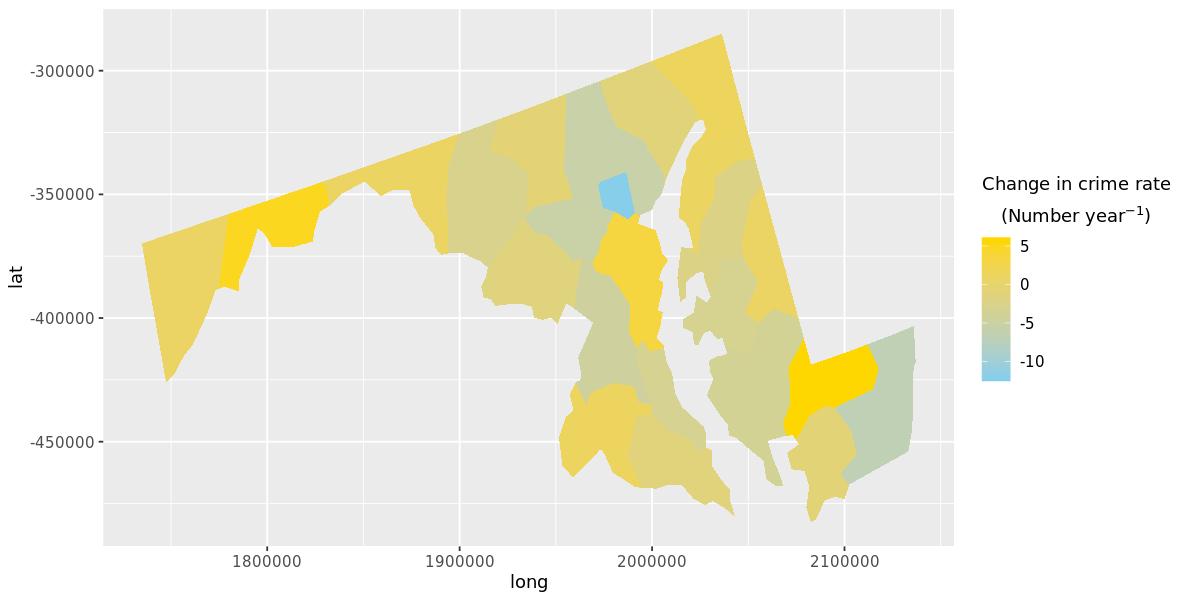

In [40]:
# Set the notebook's plot settings
options(repr.plot.width=10, repr.plot.height=5)

# Plot the results 
crime_map <- 
   ggplot(both_data, aes(long, lat, group = county, fill = YEAR_3)) +
  geom_polygon() + 
  scale_fill_continuous(name = expression(atop("Change in crime rate","(Number year"^-1*")")),
                        low = "skyblue", high = "gold")

# Look at the map
crime_map

## 11. Polish the map
<p>We are almost done. Our map shows how linear trends in crime rates varied between 1976 and 2016, but we do not have a polished figure yet.</p>
<p>Let's clean up our plot so that we can present it policymakers.</p>

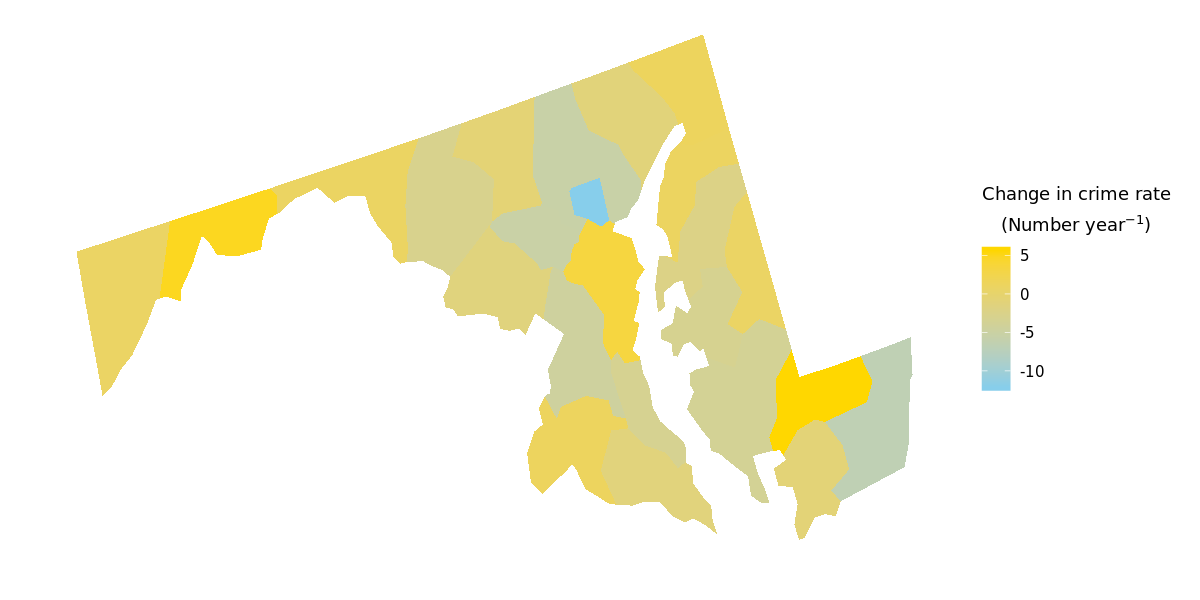

In [42]:
# Plot options
options(repr.plot.width=10, repr.plot.height=5)

# Polish figure
crime_map_final <- crime_map + 
  theme_minimal() +
  xlab("") +
  ylab("") +
  theme(axis.line=element_blank(), 
        axis.text=element_blank(), 
        panel.grid.major=element_blank(), 
        panel.grid.minor=element_blank(), 
        panel.border=element_blank(), 
        panel.background=element_blank())

# Look at the map
print(crime_map_final)

## 12. Compare populations and crime rates
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" width="45%" align="left"><img src="https://assets.datacamp.com/production/project_673/./img/crime_map.jpg" width="46%"></p>
<p>Statewide, we found no linear trend in crime rates across Maryland. But, trends in crime rates varied across the state. What should we tell a policymaker? We could say, <strong>Location is key</strong>. Crime increased in some locations but it also decreased in others.  </p>
<p>Our analysis raises other question; comparing the population figure to the crime trends figure, we see that population might affect crime rate trends. Could other explanatory variables better explain a county's crime rate? We could look for more explanatory variables in public data sources such those supplied by the <a href="https://planning.maryland.gov/msdc/Pages/default.aspx">State of Maryland</a>, the US Federal Government at <a href="https://www.data.gov">Data.gov</a>, and <a href="https://www.census.gov/data.html">the US Census Bureau</a>.</p>
<p>Also, our figure suggests a nonlinear trend in some counties. We could either use a nonlinear model or only model the crime rate for the past 10 or 20 years. <a href="https://www.datacamp.com/courses/nonlinear-modeling-in-r-with-gams">Nonlinear modeling in R with GAMS</a> covers some nonlinear models. Additionally, we could build our own, more complicated regression using a language such as JAGS, covered in <a href="https://www.datacamp.com/courses/bayesian-modeling-with-rjags">Bayesian Modeling with RJAGS</a>. The last model approach would allow us to calculate credible intervals around the random-effects. </p>
<p>To finish up, we'll quickly look to see if the population by county affects the crime rate.</p>

In [44]:
# Build a lmer with both year and population
lmer_pop <- lmer(crime_rate ~ YEAR_3 + POPULATION + (YEAR_3|JURISDICTION), data=crime_use)


# Inspect the results
summary(lmer_pop)
ranef(lmer_pop)

Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: crime_rate ~ YEAR_3 + POPULATION + (YEAR_3 | JURISDICTION)
   Data: crime_use

REML criterion at convergence: 13160.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4503 -0.4656 -0.0545  0.4325  6.5160 

Random effects:
 Groups       Name        Variance Std.Dev. Corr 
 JURISDICTION (Intercept) 188653.8 434.343       
              YEAR_3          18.3   4.278  -0.68
 Residual                  23136.1 152.106       
Number of obs: 1008, groups:  JURISDICTION, 24

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  5.338e+02  9.279e+01  2.179e+01   5.753 9.02e-06 ***
YEAR_3      -1.363e+00  1.015e+00  2.638e+01  -1.343    0.191    
POPULATION  -2.883e-05  1.549e-04  3.077e+01  -0.186    0.854    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           (Intr) YEAR_3
YEAR_3     -0.505 

$JURISDICTION
                       (Intercept)      YEAR_3
Allegany County         -327.79962   6.3680635
Anne Arundel County     -120.43136   4.9094623
Baltimore City          1769.97707 -10.8711791
Baltimore County         390.51088  -3.9126966
Calvert County          -136.76125  -1.8463195
Caroline County         -147.77350   2.1305489
Carroll County          -299.22806   0.7487660
Cecil County             -72.44335   2.7828567
Charles County           -64.21218   2.7378129
Dorchester County        149.89391  -2.2383548
Frederick County         -69.52330  -1.3972294
Garrett County          -339.92906   2.1554975
Harford County          -180.66967   0.2736064
Howard County           -125.04570  -3.7786450
Kent County             -225.45766   2.4608621
Montgomery County       -241.26907   0.2374423
Prince George's County   452.51630  -2.9877349
Queen Anne's County     -185.39495  -0.8270734
Somerset County          -76.16270   0.5202059
St. Mary's County       -155.79029   0.1308995